In [20]:
# read data from data/meddra.tsv
import pandas as pd

side_effects_path = 'data/meddra.tsv'
columns = ['UMLS_concept_id', 'MedDRA_concept_type', 'MedRA_id', 'Side_effect_name']

df = pd.read_csv(side_effects_path, sep='\t', header=None)
df.columns = columns
df.head()

,UMLS_concept_id,MedDRA_concept_type,MedRA_id,Side_effect_name
0,C0000727,LT,10000647,Acute abdomen
1,C0000727,PT,10000647,Acute abdomen
2,C0000727,LT,10042784,Syndrome abdominal acute
3,C0000727,LT,10000096,Abdominal syndrome acute
4,C0000729,LT,10000057,Abdominal cramps


In [21]:
side_effects = df['Side_effect_name'].unique()
side_effects = [str(side_effect) for side_effect in side_effects]
print('Number of unique side effects:', len(side_effects))
print('Example side effects:', side_effects[:10])

Number of unique side effects: 75604
Example side effects: ['Acute abdomen', 'Syndrome abdominal acute', 'Abdominal syndrome acute', 'Abdominal cramps', 'Abdominal cramp', 'Cramp abdominal', 'Abdominal crampy pains', 'Griping abdominal', 'Griping abdomen', 'Distended abdomen']


In [22]:
from FlagEmbedding import BGEM3FlagModel

MODEL = BGEM3FlagModel("BAAI/bge-m3", use_fp16=True)

def genEmbs(texts: list):
    embs = MODEL.encode(
        texts, return_dense=True, return_sparse=True, return_colbert_vecs=False)
    return embs['dense_vecs'], embs['lexical_weights']

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

In [23]:
limit = 75604

In [24]:
dense, sparse = genEmbs(side_effects[:limit])
print(dense.shape)

Inference Embeddings: 100%|██████████| 6301/6301 [03:09<00:00, 33.16it/s]


(75604, 1024)


In [25]:
# save as .pkl
import pickle

with open('vector_data/side_effects.pkl', 'wb') as f:
    pickle.dump(dense, f)

t-SNE part done!
DBSCAN part done!


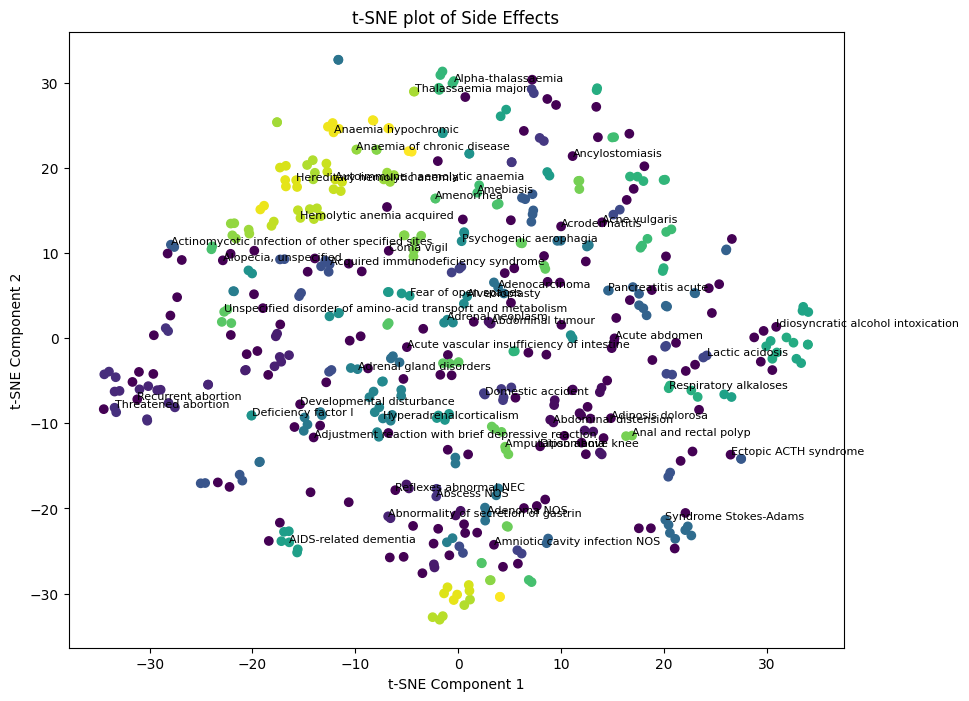

In [10]:
# plot on 2D
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(dense)
print('t-SNE part done!')

dbscan = DBSCAN(eps=1, min_samples=2)
clusters = dbscan.fit_predict(X_2d)
print('DBSCAN part done!')

plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, cmap='viridis')

for i, side_effect in enumerate(side_effects[:limit]):
    if i % 10 != 0:
        continue
    plt.annotate(side_effect, (X_2d[i, 0], X_2d[i, 1]), fontsize=8)

plt.title('t-SNE plot of Side Effects')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [19]:
import plotly.express as px
from sklearn.manifold import TSNE
import pandas as pd

tsne = TSNE(n_components=3, random_state=42)
X_3d = tsne.fit_transform(dense)

df = pd.DataFrame(X_3d, columns=['Component 1', 'Component 2', 'Component 3'])
df['Side Effect'] = side_effects[:limit]
# interpolate with empty strings to avoid overlapping labels
for idx, row in df.iterrows():
    if idx % 20 != 0:
        df.loc[idx, 'Side Effect'] = ''
df['Cluster'] = clusters
print(df.head())

fig = px.scatter_3d(df, x='Component 1', y='Component 2', z='Component 3',
                    color='Cluster', text='Side Effect', 
                    title='3D t-SNE plot of Side Effects with DBSCAN Clusters',
                    labels={'Cluster': 'Cluster Label'})

fig.update_traces(marker=dict(size=5), textposition='top center')
fig.update_layout(autosize=True, hovermode='closest')
fig.show()


   Component 1  Component 2  Component 3    Side Effect  Cluster
0     6.153812    13.011309    15.912432  Acute abdomen        0
1     9.096289    14.937145    20.314907                       0
2     7.841989    16.617062    16.430637                       0
3    15.020138    20.468021    16.006636                       1
4    16.478127    19.498373    12.399509                       1
